<a href="https://colab.research.google.com/github/fajrunwm/gisml/blob/main/Agriculture_Augmentation_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Phase 4: Model Application

In [1]:
# Mounting Google Drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Install required libraries
!pip install pystac_client planetary_computer rasterio rioxarray -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.7 MB/s eta 0:00:00


In [5]:
# Import Essential Libraries
from IPython import get_ipython
from IPython.display import display
from google.colab import drive
from pystac.extensions.eo import EOExtension as eo
from PIL import Image
from shapely import geometry
from skimage.transform import resize

import pystac_client
import planetary_computer as pc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import rioxarray as riox
import os
import time

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import rasterio
from rasterio import features, windows, warp
from rasterio.enums import Resampling
from rasterio.windows import Window
from rasterio.plot import show
from rasterio.io import MemoryFile

In [6]:
# Check for available GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f'GPU found => {physical_devices}')
    # Set memory growth to avoid memory allocation issues
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    print('No GPU found.')

GPU found => [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Access the Dataset

In [7]:
# Data access
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=pc.sign_inplace,
)

print("Connected to MPC Catalog")

Connected to MPC Catalog


In [8]:
# Define Area of Interest (AOI) of Sambas, West Kalimantan
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [109.469061, 1.521933],  # Left Top
            [109.658273, 1.521933],  # Right Top
            [109.658273, 1.328140],  # Right Bottom
            [109.469061, 1.328140],  # Left Bottom
            [109.469061, 1.521933],  # Closing the polygon
        ]
    ],
}

In [9]:
# Define Date Range
date = "2024-01-01/2025-12-31"

In [10]:
# Define Could Cover tolerance
cc = 10

In [11]:
# Search for Sentinel-2 data with cloud cover filter
search = catalog.search(
    collections=["sentinel-2-l2a"],  # Dataset
    intersects=aoi,    # Area of Interest
    datetime=date,  # Date range
    query={"eo:cloud_cover": {"lt": cc}},  # Cloud cover filter (<10%)
)

In [12]:
# Check how many items were found
items = list(search.items())
print(f"Found {len(items)} items with cloud cover < {cc}%:")
for i in items:
    print(f"<> {i.datetime.date()} | cloud cover {eo.ext(i).cloud_cover}% | {i.id}")

Found 4 items with cloud cover < 10%:
<> 2024-10-27 | cloud cover 8.76089% | S2B_MSIL2A_20241027T024719_R132_T49NCB_20241027T045913
<> 2024-07-27 | cloud cover 4.239946% | S2A_MSIL2A_20240727T025531_R032_T49NCB_20240727T092050
<> 2024-07-24 | cloud cover 8.236793% | S2A_MSIL2A_20240724T024551_R132_T49NCB_20240724T090850
<> 2024-04-30 | cloud cover 5.723482% | S2B_MSIL2A_20240430T024529_R132_T49NCB_20240430T071020


In [13]:
# Choose the least cloudy item
least_cloudy_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
    f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover."
)

Choosing S2A_MSIL2A_20240727T025531_R032_T49NCB_20240727T092050 from 2024-07-27 with 4.239946% cloud cover.


## Visualise the Area of Interest (AOI)

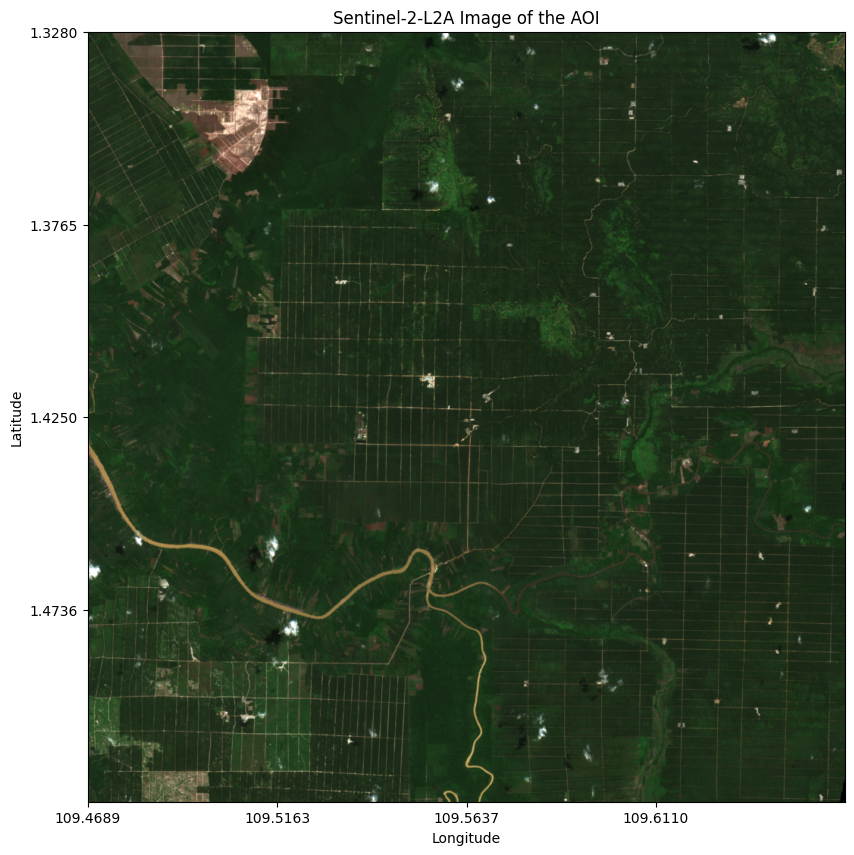

In [14]:
# Assuming 'least_cloudy_item', 'aoi', and 'band_data' are already defined
with rasterio.open(least_cloudy_item.assets["visual"].href) as ds:
    # Get image bounds in dataset's CRS
    aoi_bounds = features.bounds(aoi)
    warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
    aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)

    # Read band data for the AOI
    band_data = ds.read(window=aoi_window)

# Create image and resize
img = Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
w, h = img.size
aspect = w / h
target_w = 1000
target_h = int(target_w / aspect)
img = img.resize((target_w, target_h), Image.Resampling.BILINEAR)

# Get dataset bounds in EPSG:4326 for coordinate grid
aoi_bounds = ds.window_bounds(aoi_window)  # Get bounds from the dataset window
left, bottom, right, top = warp.transform_bounds(ds.crs, "epsg:4326", *aoi_bounds)  # Get bounds in EPSG:4326

# Plotting with coordinate axes
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)

# Set coordinate grid and labels
lon_ticks = np.linspace(left, right, 5)
lat_ticks = np.linspace(bottom, top, 5)

x_coords = np.linspace(0, img.size[0], len(lon_ticks))
y_coords = np.linspace(0, img.size[1], len(lat_ticks))

ax.xaxis.set_major_locator(plt.FixedLocator(x_coords))
ax.xaxis.set_major_formatter(plt.FixedFormatter([f"{lon:.4f}" for lon in lon_ticks]))

ax.yaxis.set_major_locator(plt.FixedLocator(y_coords))
ax.yaxis.set_major_formatter(plt.FixedFormatter([f"{lat:.4f}" for lat in lat_ticks]))

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.title("Sentinel-2-L2A Image of the AOI")
plt.show()

# Print the image size
print(f"AOI Image size: {target_w} (width) x {target_h} (height)")

## Assign Images to Inference

In [15]:
# Sign the item's assets for direct access
signed_item = pc.sign(least_cloudy_item)

# Collect band information
band_info = []

for asset_key, asset in signed_item.assets.items():
    bands = asset.extra_fields.get('eo:bands', [])
    for band in bands:
        band_info.append({
            "Asset Title": asset.title,
            #"Asset": asset_key,
            "Band Name": band.get("name", "N/A"),
            "Common Name": band.get("common_name", "N/A"),
            "Resolution (m)": asset.extra_fields.get("gsd", "N/A"),  # Extract spatial resolution
            "Center Wavelength (µm)": band.get("center_wavelength", "N/A"),
            "Full Width Half Max (µm)": band.get("full_width_half_max", "N/A"),
        })

In [16]:
# Define the Sentinel-2 bands to use for the composite
band_names = [
    "B02", # Blue
    "B03", # Green
    "B04", # Red
    "B06", # Vegetation red edge 2
    "B08", # NIR band
]

In [17]:
# Find the matching assets from the signed item
band_assets = {}
for band in band_names:
    asset = next(
        (asset for asset_key, asset in signed_item.assets.items()
         if asset.extra_fields.get("eo:bands", [{}])[0].get("name") == band),
        None,
    )
    if asset:
        band_assets[band] = asset.href

# Ensure we have all the bands
if len(band_assets) != len(band_names):
    missing_bands = set(band_names) - set(band_assets.keys())
    raise ValueError(f"Missing bands: {missing_bands}")

In [18]:
# Assign Band 02 AOI as a single layer
with rasterio.open(band_assets["B02"]) as blue_src:
    # Transform AOI bounds to the dataset's CRS
    aoi_bounds = features.bounds(aoi)
    aoi_pixel_bounds = windows.from_bounds(
        *warp.transform_bounds("epsg:4326", blue_src.crs, *aoi_bounds),
        transform=blue_src.transform
    )

    # Read the data within the AOI
    aoi_window = windows.Window(
        col_off=int(aoi_pixel_bounds.col_off),
        row_off=int(aoi_pixel_bounds.row_off),
        width=int(aoi_pixel_bounds.width),
        height=int(aoi_pixel_bounds.height),
    )

    band2_aoi = blue_src.read(1, window=aoi_window)

    # Get dataset bounds in EPSG:4326 for the grid (for the cropped AOI)
    aoi_bounds = blue_src.window_bounds(aoi_window)
    lon_min, lat_min, lon_max, lat_max = warp.transform_bounds(blue_src.crs, "epsg:4326", *aoi_bounds)

print(band2_aoi.shape)

(2144, 2106)


In [19]:
# Assign Band 03 AOI as a single layer
with rasterio.open(band_assets["B03"]) as green_src:
    # Transform AOI bounds to the dataset's CRS
    aoi_bounds = features.bounds(aoi)
    aoi_pixel_bounds = windows.from_bounds(
        *warp.transform_bounds("epsg:4326", green_src.crs, *aoi_bounds),
        transform=green_src.transform
    )

    # Read the data within the AOI
    aoi_window = windows.Window(
        col_off=int(aoi_pixel_bounds.col_off),
        row_off=int(aoi_pixel_bounds.row_off),
        width=int(aoi_pixel_bounds.width),
        height=int(aoi_pixel_bounds.height),
    )

    band3_aoi = green_src.read(1, window=aoi_window)

    # Get dataset bounds in EPSG:4326 for the grid (for the cropped AOI)
    aoi_bounds = green_src.window_bounds(aoi_window)
    lon_min, lat_min, lon_max, lat_max = warp.transform_bounds(green_src.crs, "epsg:4326", *aoi_bounds)

print(band3_aoi.shape)

(2144, 2106)


In [20]:
# Assign Band 04 AOI as a single layer
with rasterio.open(band_assets["B04"]) as red_src:
    # Transform AOI bounds to the dataset's CRS
    aoi_bounds = features.bounds(aoi)
    aoi_pixel_bounds = windows.from_bounds(
        *warp.transform_bounds("epsg:4326", red_src.crs, *aoi_bounds),
        transform=red_src.transform
    )

    # Read the data within the AOI
    aoi_window = windows.Window(
        col_off=int(aoi_pixel_bounds.col_off),
        row_off=int(aoi_pixel_bounds.row_off),
        width=int(aoi_pixel_bounds.width),
        height=int(aoi_pixel_bounds.height),
    )

    band4_aoi = red_src.read(1, window=aoi_window)

    # Get dataset bounds in EPSG:4326 for the grid (for the cropped AOI)
    aoi_bounds = red_src.window_bounds(aoi_window)
    lon_min, lat_min, lon_max, lat_max = warp.transform_bounds(red_src.crs, "epsg:4326", *aoi_bounds)

print(band4_aoi.shape)

(2144, 2106)


In [21]:
# Assign Band 06 AOI as a single layer and Resample into the same resolution
with rasterio.open(band_assets["B06"]) as red_edge_src:
    # Transform AOI bounds to the dataset's CRS
    aoi_bounds = features.bounds(aoi)
    aoi_pixel_bounds = windows.from_bounds(
        *warp.transform_bounds("epsg:4326", red_edge_src.crs, *aoi_bounds),
        transform=red_edge_src.transform
    )

    # Read the data within the AOI
    aoi_window = windows.Window(
        col_off=int(aoi_pixel_bounds.col_off),
        row_off=int(aoi_pixel_bounds.row_off),
        width=int(aoi_pixel_bounds.width),
        height=int(aoi_pixel_bounds.height),
    )

    band6_aoi = red_edge_src.read(1, window=aoi_window)

    # Get dataset bounds in EPSG:4326 for the grid (for the cropped AOI)
    aoi_bounds = red_edge_src.window_bounds(aoi_window)
    lon_min, lat_min, lon_max, lat_max = warp.transform_bounds(red_edge_src.crs, "epsg:4326", *aoi_bounds)

print(band6_aoi.shape)

# Image Resampling for Band 06
# Create an in-memory dataset from band6_aoi
with rasterio.io.MemoryFile() as memfile:
    with memfile.open(
        driver='GTiff',
        height=band6_aoi.shape[0],
        width=band6_aoi.shape[1],
        count=1,  # Single band
        dtype=band6_aoi.dtype,
        crs=red_edge_src.crs,  # Use the CRS from the original source
        transform=red_edge_src.transform,  # Use the transform from the original source
    ) as dataset:
        dataset.write(band6_aoi, 1)  # Write the band data

        # Set upscale factor (20m to 10m => factor of 2)
        upscale_factor = 2

        # Calculate new height and width using the upscale factor
        new_width = dataset.width * upscale_factor
        new_height = dataset.height * upscale_factor

        # Generate new transform
        new_transform = dataset.transform * dataset.transform.scale(
            1 / upscale_factor, 1 / upscale_factor
        )

        # Create a new array to hold the resampled data
        band6_aoi = dataset.read(
            out_shape=(1, int(new_height), int(new_width)),
            resampling=Resampling.bilinear,  # Choose the resampling method
        )
        band6_aoi = np.squeeze(band6_aoi)

print(band6_aoi.shape)

(1072, 1053)
(2144, 2106)


In [22]:
# Assign Band 08 AOI as a single layer
with rasterio.open(band_assets["B08"]) as nir_src:
    # Transform AOI bounds to the dataset's CRS
    aoi_bounds = features.bounds(aoi)
    aoi_pixel_bounds = windows.from_bounds(
        *warp.transform_bounds("epsg:4326", nir_src.crs, *aoi_bounds),
        transform=nir_src.transform
    )

    # Read the data within the AOI
    aoi_window = windows.Window(
        col_off=int(aoi_pixel_bounds.col_off),
        row_off=int(aoi_pixel_bounds.row_off),
        width=int(aoi_pixel_bounds.width),
        height=int(aoi_pixel_bounds.height),
    )

    band8_aoi = nir_src.read(1, window=aoi_window)

    # Get dataset bounds in EPSG:4326 for the grid (for the cropped AOI)
    aoi_bounds = nir_src.window_bounds(aoi_window)
    lon_min, lat_min, lon_max, lat_max = warp.transform_bounds(nir_src.crs, "epsg:4326", *aoi_bounds)

print(band8_aoi.shape)

(2144, 2106)


In [23]:
# Create a stack layer
stacked_bands = np.stack([band2_aoi, band3_aoi, band4_aoi, band6_aoi, band8_aoi], axis=-1)
stacked_bands.shape

(2144, 2106, 5)

In [24]:
# Stack and save all bands together ===> mismatched coordinates, correct result
def stack_bands(band_data_list, stacked_file):
    # Assuming band_data_list is a list of band data arrays

    # Get metadata from the first band
    with rasterio.open(band_assets["B02"]) as blue_src:  # Open the first band file
        meta = blue_src.meta
        crs = blue_src.crs
        transform = blue_src.transform

    # Create an in-memory dataset for the template using the metadata
    with rasterio.io.MemoryFile() as memfile:
        with memfile.open(
            driver='GTiff',
            height=band_data_list[0].shape[0],
            width=band_data_list[0].shape[1],
            count=1,  # Single band for template
            dtype=band_data_list[0].dtype,
            crs=crs,  # Use CRS from the first band
            transform=transform, # Use transform from the first band
        ) as dataset:
            # Write the first band to get the metadata
            dataset.write(band_data_list[0], 1)
            meta = dataset.meta

    # Update metadata for the stack
    meta.update(count=len(band_data_list), dtype=rasterio.uint16)

    with rasterio.open(stacked_file, 'w', **meta) as dst:
        for i, band_data in enumerate(band_data_list):
            dst.write(band_data, i + 1)

# Define the files path
base_path = '/content/drive/MyDrive/Colab Notebooks/AgrAug/inference/'
os.makedirs(base_path, exist_ok=True) # Create the output directory if it doesn't exist
date_str = least_cloudy_item.datetime.date().strftime("%Y-%m-%d")
stacked_file = os.path.join(base_path, f"stacked_aoi_{date_str}_a.tif")

# Assuming you have band2_aoi, band3_aoi, band4_aoi, band6_aoi, band8_aoi as arrays:
stack_bands([band2_aoi, band3_aoi, band4_aoi, band6_aoi, band8_aoi], stacked_file)

print(f"All bands stacked and saved to {stacked_file}")

All bands stacked and saved to /content/drive/MyDrive/Colab Notebooks/AgrAug/inference/stacked_aoi_2024-07-27_a.tif


In [ ]:
# Stack and save all bands together ===> correct coordinates, mismatched result
def stack_bands(band_assets, stacked_file, aoi_bounds, aoi_window):

    band_data_list = []

    # Extract data for AOI from each band and verify shape
    for band_name, band_file in band_assets.items():
        with rasterio.open(band_file) as src:
            band_data = src.read(1, window=aoi_window)  # Read AOI window
            band_data_list.append(band_data)

            if band_name == "B02":
                # Use the metadata from the first band (reference metadata)
                crs = src.crs
                transform = src.window_transform(aoi_window)

    # Prepare metadata for stacking
    meta = {
        "driver": "GTiff",
        "dtype": band_data_list[0].dtype,
        "width": band_data_list[0].shape[1],
        "height": band_data_list[0].shape[0],
        "count": len(band_data_list),  # Number of bands to stack
        "crs": crs,
        "transform": transform,
    }

    # Write stacked bands to a new file
    with rasterio.open(stacked_file, "w", **meta) as dst:
        for i, band_data in enumerate(band_data_list):
            dst.write(band_data, i + 1)  # Write each band to the corresponding layer

# Define AOI bounds and window from the second snippet
with rasterio.open(band_assets["B08"]) as nir_src:
    aoi_bounds = features.bounds(aoi)
    aoi_pixel_bounds = rasterio.windows.from_bounds(
        *warp.transform_bounds("epsg:4326", nir_src.crs, *aoi_bounds),
        transform=nir_src.transform,
    )
    aoi_window = Window(
        col_off=int(aoi_pixel_bounds.col_off),
        row_off=int(aoi_pixel_bounds.row_off),
        width=int(aoi_pixel_bounds.width),
        height=int(aoi_pixel_bounds.height),
    )

# Path for the stacked file
base_path = '/content/drive/MyDrive/Colab Notebooks/AgrAug/inference/'
os.makedirs(base_path, exist_ok=True)  # Create directory if it doesn't exist
date_str = least_cloudy_item.datetime.date().strftime("%Y-%m-%d")
stacked_file = os.path.join(base_path, f"stacked_aoi_{date_str}_b.tif")

# Call the adjusted stacking function
stack_bands(band_assets, stacked_file, aoi_bounds, aoi_window)

print(f"All bands stacked and saved to {stacked_file}")

All bands stacked and saved to /content/drive/MyDrive/Colab Notebooks/AgrAug/inference/stacked_aoi_2024-07-27.tif


In [22]:
# Stack and save all bands together ===> .......... coordinates, .......... result
def stack_bands(band_assets, stacked_file, aoi_bounds):
    band_data_list = []

    with rasterio.open(band_assets["B02"]) as ref_src:
        # Transform AOI bounds to match band CRS
        aoi_bounds_transformed = warp.transform_bounds("epsg:4326", ref_src.crs, *aoi_bounds)

        # Define AOI window
        aoi_window = rasterio.windows.from_bounds(*aoi_bounds_transformed, transform=ref_src.transform)

        # Reference CRS, transform, and metadata
        crs = ref_src.crs
        transform = ref_src.window_transform(aoi_window)

    # Extract data for AOI from each band
    for band_name, band_file in band_assets.items():
        with rasterio.open(band_file) as src:
            band_data = src.read(1, window=aoi_window)  # Clip each band to AOI window
            band_data_list.append(band_data)

    # Prepare unified metadata
    meta = {
        "driver": "GTiff",
        "dtype": band_data_list[0].dtype,
        "width": band_data_list[0].shape[1],
        "height": band_data_list[0].shape[0],
        "count": len(band_data_list),
        "crs": crs,
        "transform": transform,
    }

    # Write stacked bands to GeoTIFF
    with rasterio.open(stacked_file, "w", **meta) as dst:
        for i, band_data in enumerate(band_data_list):
            dst.write(band_data, i + 1)

# Define paths and parameters
base_path = '/content/drive/MyDrive/Colab Notebooks/AgrAug/inference/'
os.makedirs(base_path, exist_ok=True)  # Ensure directory exists
date_str = least_cloudy_item.datetime.date().strftime("%Y-%m-%d")
stacked_file = os.path.join(base_path, f"stacked_aoi_{date_str}_c.tif")

# Assuming 'band_assets' is a dictionary with band paths and 'aoi' defines the area of interest
with rasterio.open(band_assets["B08"]) as nir_src:
    aoi_bounds = features.bounds(aoi)

# Call the function
stack_bands(band_assets, stacked_file, aoi_bounds)

print(f"All bands stacked and saved to {stacked_file}")

All bands stacked and saved to /content/drive/MyDrive/Colab Notebooks/AgrAug/inference/stacked_aoi_2024-07-27_c.tif


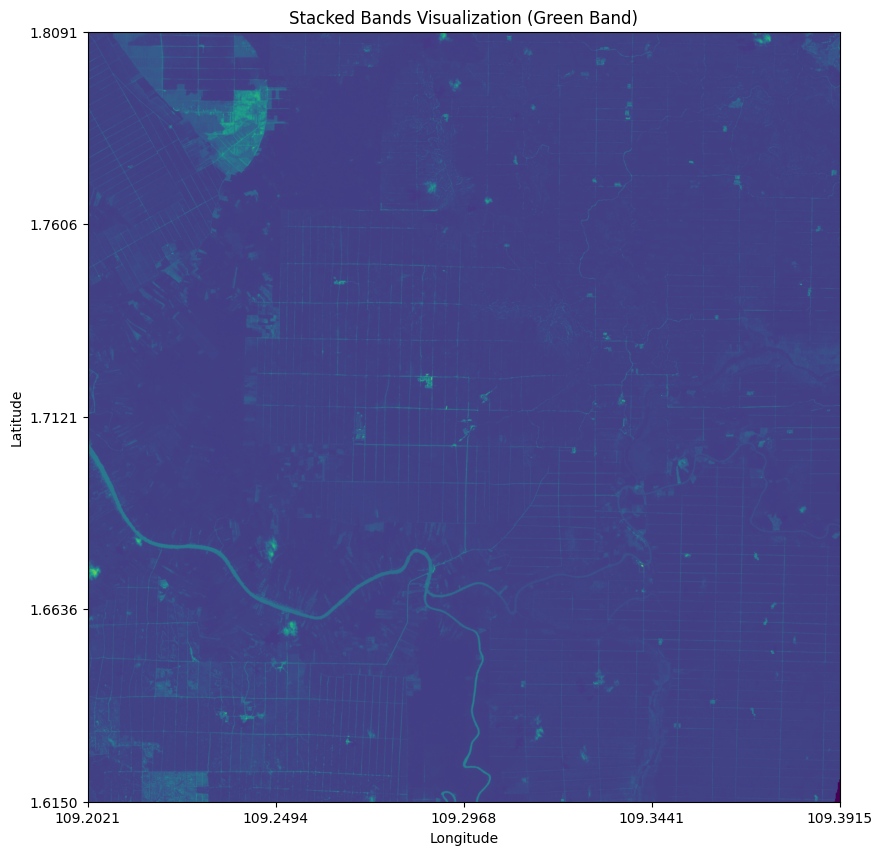

In [25]:
# Assuming stacked_file is defined and points to your stacked GeoTIFF file
with rasterio.open(stacked_file) as src:
    stacked_bands = src.read()  # Read all bands
    transform = src.transform
    crs = src.crs

# Get bounds in EPSG:4326
left, bottom, right, top = warp.transform_bounds(src.crs, "epsg:4326", *src.bounds)

# Choose a band for visualization (e.g., band 3 - Green)
visualization_band = stacked_bands[2, :, :]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))
image = ax.imshow(visualization_band, extent=[left, right, bottom, top], origin="upper")

# Set coordinate grid and labels
lon_ticks = np.linspace(left, right, 5)  # Longitude ticks
lat_ticks = np.linspace(bottom, top, 5)  # Latitude ticks

ax.set_xticks(lon_ticks)
ax.set_yticks(lat_ticks)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.4f}"))  # Format longitude
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.4f}"))  # Format latitude

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.title("Stacked Bands Visualization (Green Band)")
plt.show()

## Generate the Oil Palm Health Map

In [26]:
# Load the trained model
model = load_model('/content/drive/MyDrive/Colab Notebooks/AgrAug/model/overlap50_256_v3.keras', compile=False)

# Check the model's input shape
print(f"\nInput shape: {model.input_shape}")

# Check the model's output shape
print(f"\nOutput shape: {model.output_shape}")


Input shape: (None, 256, 256, 5)

Output shape: (None, 256, 256, 6)


In [27]:
# Load and Preprocess the Image
def load_geotiff_as_numpy(stacked_file):
    with rasterio.open(stacked_file) as src:
        image_data = src.read()
        image_data = np.transpose(image_data, (1, 2, 0))
        return image_data

image = load_geotiff_as_numpy(stacked_file)
print("Image shape:", image.shape)

# Patch the Image
patch_size = (256, 256)
overlap = 30  # Adjust overlap as needed

def patch_image_with_coords(image, patch_size, overlap):
    height, width, channels = image.shape
    patches = []
    patch_coords = []
    for y in range(0, height, patch_size[0] - overlap):
        for x in range(0, width, patch_size[1] - overlap):
            y_end = min(y + patch_size[0], height)
            x_end = min(x + patch_size[1], width)
            patch = image[y:y_end, x:x_end]

            # Pad if patch is smaller than patch_size
            if patch.shape[:2] != patch_size:
                pad_height = patch_size[0] - patch.shape[0]
                pad_width = patch_size[1] - patch.shape[1]
                patch = np.pad(patch, ((0, pad_height), (0, pad_width), (0, 0)), mode='reflect')

            patches.append(patch)
            patch_coords.append((y, x))
    return patches, patch_coords

# Calculate total inference time
# Start timing the inference process
start_time = time.time()

# Make Predictions on Patches
def predict_on_patches(model, patches):
    predictions = []
    for patch in patches:
        prediction = model.predict(np.expand_dims(patch, axis=0))
        predictions.append(prediction[0])
    return predictions

# Merge Predictions
def merge_predictions(predictions, patch_coords, image_shape, patch_size):
    merged_prediction = np.zeros((image_shape[0], image_shape[1], 6))
    for i, patch_prediction in enumerate(predictions):
        y, x = patch_coords[i]
        y_end = min(y + patch_size[0], image_shape[0])
        x_end = min(x + patch_size[1], image_shape[1])
        merged_prediction[y:y_end, x:x_end] = patch_prediction[:y_end - y, :x_end - x]
    return merged_prediction

# Define the 'model', 'stacked_file', 'patch_size', and 'overlap'
image = load_geotiff_as_numpy(stacked_file)
patches, patch_coords = patch_image_with_coords(image, patch_size, overlap)
predictions = predict_on_patches(model, patches)
merged_prediction = merge_predictions(predictions, patch_coords, image.shape, patch_size)

print("Merged prediction shape:", merged_prediction.shape)

# End timing the inference process
end_time = time.time()

# Calculate total inference time
total_training_time = end_time - start_time

# Convert total inference time to minutes and seconds
minutes, seconds = divmod(total_training_time, 60)
print(f'Total inference time: {int(minutes)} minutes and {seconds:.2f} seconds')

Image shape: (2144, 2106, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━

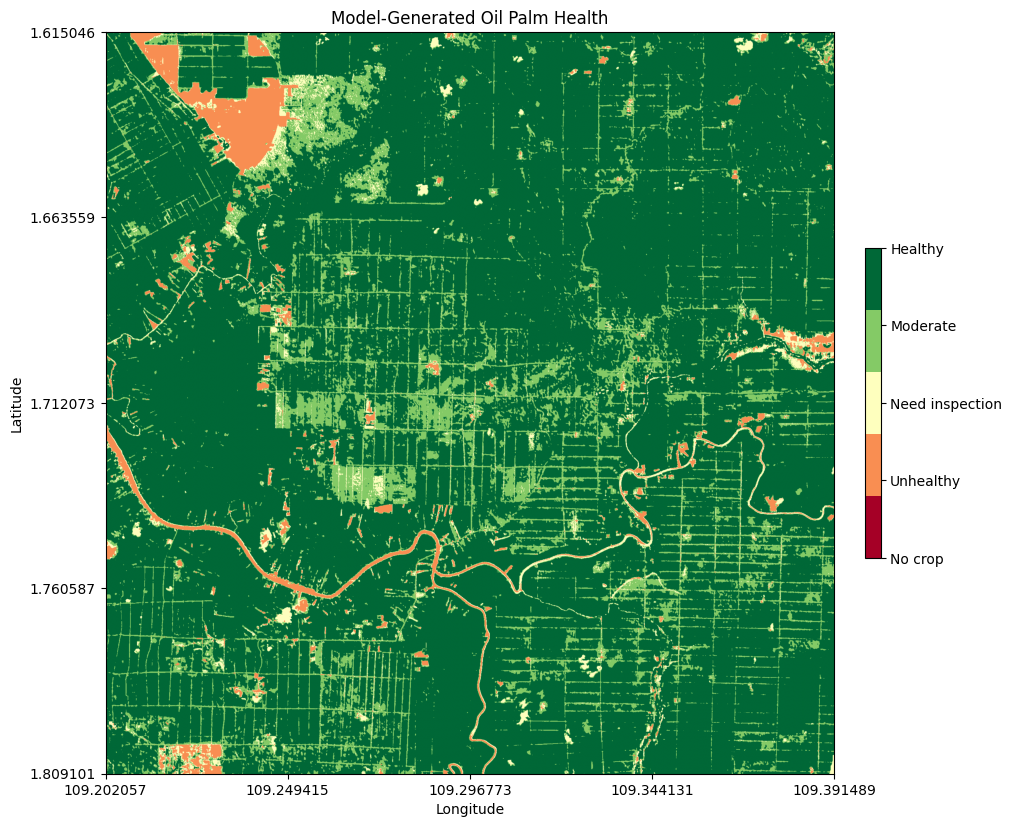

In [28]:
# Load GeoTIFF with rasterio
with rasterio.open(stacked_file) as src:
    transform = src.transform  # Get the affine transformation
    crs = src.crs  # Get the CRS
    width = src.width
    height = src.height

# Convert to Class Labels
class_prediction = np.argmax(merged_prediction, axis=-1)

# Define discrete colors
n_classes = 5
base_cmap = plt.cm.RdYlGn
discrete_cmap = mcolors.ListedColormap(base_cmap(np.linspace(0, 1, n_classes)))

# Visualize the result of the overlayed classification
fig, ax = plt.subplots(figsize=(10, 10))

# Use a suitable colormap for discrete classes
cax = ax.imshow(class_prediction, cmap=discrete_cmap, vmin=0, vmax=4)

# Set coordinate grid and labels
ax.set_xlim(0, width)
ax.set_ylim(height, 0)

# Reproject the bounds to EPSG:4326
left, bottom, right, top = rasterio.warp.transform_bounds(src.crs, 'EPSG:4326', *rasterio.transform.array_bounds(height, width, transform))

# Define ticks based on bounds
lon_ticks = np.linspace(left, right, 5)
lat_ticks = np.linspace(bottom, top, 5)

ax.set_xticks(np.linspace(0, width, len(lon_ticks)))
ax.set_xticklabels([f"{lon:.6f}" for lon in lon_ticks])  # Format longitude ticks

ax.set_yticks(np.linspace(0, height, len(lat_ticks)))
ax.set_yticklabels([f"{lat:.6f}" for lat in lat_ticks])  # Format latitude ticks

# Add a discrete colorbar based on class values
cbar = plt.colorbar(cax, ax=ax, ticks=np.arange(5), fraction=0.02, pad=0.04)

# Assign the discrete class labels to the colorbar
cbar.set_ticks(np.arange(n_classes))
cbar.set_ticklabels(['No crop', 'Unhealthy', 'Need inspection', 'Moderate', 'Healthy'])

# Set labels and title
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.title("Model-Generated Oil Palm Health")

# Show plot
plt.show()

In [29]:
# Save the model-generated oil palm health classification as a GeoTIFF
output_file = os.path.join(base_path, f"oil_palm_health_{date_str}_a.tif")

with rasterio.open(stacked_file) as src:
    profile = src.profile
    profile.update(
        dtype=rasterio.uint8,  # Set the data type to uint8
        count=1,  # Number of bands (1 for classification)
        compress='lzw' # Use LZW compression for better storage efficiency
    )

    with rasterio.open(output_file, 'w', **profile) as dst:
        dst.write(class_prediction.astype(rasterio.uint8), 1)

print(f"Model-generated oil palm health saved to {output_file}")

Model-generated oil palm health saved to /content/drive/MyDrive/Colab Notebooks/AgrAug/inference/oil_palm_health_2024-07-27_a.tif
